In [ ]:
import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist

# for CI testing
smoke_test = ('CI' in os.environ)
# assert pyro.__version__.startswith('1.8.6')
pyro.set_rng_seed(1)


# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

ModuleNotFoundError: No module named 'seaborn'

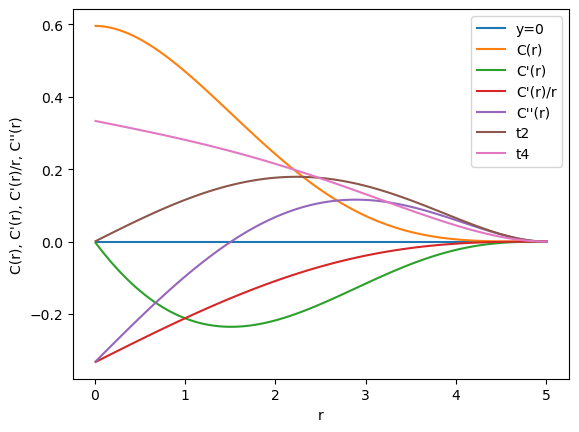

In [ ]:
a_T = 5
c_o_T = a_T**2/14/3
c_o_T
def covariance_function(r):
    r_by_at = r/a_T
    C_r = c_o_T *( 1 - 7 * (r_by_at)**2 + 8.75 * (r_by_at)**3 - 3.5 * (r_by_at)**5 + 0.75 * (r_by_at)**7)
    return C_r
def first_derivative_covariance_function(r):
    C_r_dash =c_o_T *( - 14 * (r/a_T**2) + 105/4 * (r**2/a_T**3) - 35/2 * (r**4/a_T**5) + 21/4 * (r**6/a_T**7))
    # C_r_dash =c_o_T *( - 14 * (r_by_at)**2 + 105/4 * (r_by_at)**3 - 35/2 * (r_by_at)**5 + 21/4 * (r_by_at)**7)/ r

    return C_r_dash
def first_derivative_covariance_function_divided_by_r(r):
    C_r_dash_by_r = c_o_T *( - 14 / ((a_T)**2) + 105/4 * (r/(a_T)**3) - 35/2 * (r**3/(a_T)**5) + 21/4 * (r**5/(a_T)**7))
    return C_r_dash_by_r
def second_derivative_covariance_function(r):
    C_r_dash_dash =c_o_T * 7 * (9 * r ** 5 - 20 * a_T ** 2 * r ** 3 + 15 * a_T ** 4 * r - 4 * a_T ** 5) / (2 * a_T ** 7)
    return C_r_dash_dash
# plot the function
r =torch.linspace(0.01,a_T, 100)
C_r = covariance_function(r)
C_r_dash = first_derivative_covariance_function(r)
C_r_dash_by_r = first_derivative_covariance_function_divided_by_r(r)
C_r_dash_dash = second_derivative_covariance_function(r)
t2 = - first_derivative_covariance_function_divided_by_r(r) + second_derivative_covariance_function(r)
t4 = 0.6 * t2 -C_r_dash_by_r
plt.plot(r,torch.zeros(len(r)))
plt.plot(r,C_r)
plt.plot(r,C_r_dash)
plt.plot(r,C_r_dash_by_r)
plt.plot(r, C_r_dash_dash)
plt.plot(r, t2)
plt.plot(r, t4)
plt.xlabel("r")
plt.ylabel("C(r), C'(r), C'(r)/r, C''(r)")
plt.legend(["y=0","C(r)", "C'(r)","C'(r)/r", "C''(r)","t2", "t4"])
plt.show()

In [ ]:
def squared_euclidean_distance(x_1,x_2, Transformation_matrix=torch.eye(2)):
    x_1 = x_1 @ Transformation_matrix.T
    x_2 = x_2 @ Transformation_matrix.T

    sqd = torch.sqrt(torch.clip(torch.reshape(torch.sum(x_1**2,1),shape =(x_1.shape[0],1))+\
    torch.reshape(torch.sum(x_2**2,1),shape =(1,x_2.shape[0]))-\
    2*( x_1@ x_2.T), min=0.0)+ 1e-12)
    
    return sqd

In [ ]:
def cartesian_dist_hu(x1, x2, Transformation_matrix=torch.eye(2) ):
    x1 = x1@ Transformation_matrix.T
    x2 = x2@ Transformation_matrix.T
    k = x1.shape[1]
    H =[]
    dummy_H = []
    # We converted x' = x A . 
    # There for delta x' = h_u (old) = delta x A
    for i in range(k):
        delta_x_i = x1[:,i] - torch.reshape(x2[:,i], shape=(x2.shape[0],1))
        H.append(delta_x_i)
    for i in range(k):
        a=torch.zeros(H[i].shape)
        for j in range(k):
            a= a +  Transformation_matrix[j,i] * H[j]
        dummy_H.append(a)
    H = dummy_H
    return H

In [ ]:
def cov_gradients(dist_tiled, H, Transformation_matrix=torch.eye(2), nugget_effect_grad=1/3):
    k = len(H) # component of gradient available
    n = int(H[0].shape[0]/ k) # number of place where gradient is defined

    #################################################################################################
    # For cross term of gradient 
    #################################################################################################
    # if we have many component of Gradient, we can club it to make , H =[h_u, h_v, h_w,....] 
    #H =[h_u, h_v] 
    C_G = torch.zeros((n*k, n*k))
    for i in range(len(H)):
        for j in range(len(H)):
            hu_hv = H[i][n*i:n*(i+1), n*j:n*(j+1)] * H[j][n*i:n*(i+1), n*j:n*(j+1)]
            dist =dist_tiled[n*i:n*(i+1), n*j:n*(j+1)]
            dist_sqr = dist **2 
            condition = dist_sqr!=0
            hu_hv_by_dist_sqr = torch.where(condition, hu_hv/ dist_sqr, 0.0)
            
            # Cross gradient term for C_ZuZv
            if i != j:
                t2 = - first_derivative_covariance_function_divided_by_r(dist) + second_derivative_covariance_function(dist)
                anisotrop_term = first_derivative_covariance_function_divided_by_r(dist) * torch.sum(Transformation_matrix[:,i]*Transformation_matrix[:,j])
                array_test = -(hu_hv_by_dist_sqr * t2 + anisotrop_term)
                for l in range(n):
                    for m in range(n):
                        C_G[i*n+l,j*n+m] = array_test[l,m]
            # Gradient for similar type of gradient
            else:
                dist_cube = dist **3
                condition = dist_cube!=0
                hu_hv_by_dist_cube = torch.where(condition, hu_hv/dist_cube, 0.0)
                
                t4 = first_derivative_covariance_function(dist)
                
                # Here we have added the last term for anisotropy effect
                t5 = torch.sum((Transformation_matrix[:,i])**2) * first_derivative_covariance_function_divided_by_r(dist) 
                
                t6 = second_derivative_covariance_function(dist)
                
                ################################# Note ############################################
                # Covariance of gradient is negative for points closer to zero
                ##################################################################################
        
                array_test = -(- t4 * hu_hv_by_dist_cube + t5 +  t6 * hu_hv_by_dist_sqr )
                for l in range(n):
                    for m in range(n):
                        C_G[i*n+l,j*n+m] = array_test[l,m]
    # If the distance is greater than a, then function C_z(r) = 0 . 
    # Therefore, we can replace the element of covariance matrix with 0 for distance greater than a
    condition_1 = dist_tiled<=a_T
    
    C_G = torch.where(condition_1, C_G, 0.0)
    C_G = C_G + nugget_effect_grad * torch.eye(n*k)

    return C_G

In [ ]:
def cov_interface(ref_layer_points,rest_layer_points, Transformation_matrix=torch.eye(2),nugget_effect_interface=1/3):
    sed_rest_rest = squared_euclidean_distance(rest_layer_points,rest_layer_points, Transformation_matrix=Transformation_matrix)
    sed_ref_rest = squared_euclidean_distance(ref_layer_points,rest_layer_points, Transformation_matrix=Transformation_matrix)
    sed_rest_ref = squared_euclidean_distance(rest_layer_points,ref_layer_points, Transformation_matrix=Transformation_matrix)
    sed_ref_ref = squared_euclidean_distance(ref_layer_points,ref_layer_points, Transformation_matrix=Transformation_matrix)
    
    C_I = covariance_function(sed_rest_rest) -\
          covariance_function(sed_ref_rest) -\
          covariance_function(sed_rest_ref) +\
          covariance_function(sed_ref_ref)

    return C_I + nugget_effect_interface * torch.eye(C_I.shape[0])

In [ ]:
## Cartesian distance between dips and interface points

def cartesian_dist_no_tile(x_1,x_2, Transformation_matrix=torch.eye(2)):
    x_1 = x_1 @ Transformation_matrix.T
    x_2 = x_2 @ Transformation_matrix.T
    k = x_1[0].shape[0]
    H_I = []
    for i in range(k):
        H_I.append(((x_1[:,i] - torch.reshape(x_2[:,i],[x_2.shape[0],1]))).T)
    
    Dummy_H_I=[]
    
    for i in range(k):
        a=torch.zeros(H_I[i].shape)
        for j in range(k):
            a= a + Transformation_matrix[j,i] * H_I[j]
        Dummy_H_I.append(a)
    
    H_I = Dummy_H_I
    H_I = torch.concat(H_I,axis=0)
    
    return H_I


In [ ]:
def cov_interface_gradients(hu_rest,hu_ref, Position_G_Modified, rest_layer_points, ref_layer_points, Transformation_matrix=torch.eye(2)):
    sed_dips_rest = squared_euclidean_distance(Position_G_Modified,rest_layer_points,Transformation_matrix=Transformation_matrix)
    sed_dips_ref = squared_euclidean_distance(Position_G_Modified,ref_layer_points,Transformation_matrix=Transformation_matrix)
    
    C_GI = - hu_rest * first_derivative_covariance_function_divided_by_r(sed_dips_rest) + hu_ref* first_derivative_covariance_function_divided_by_r(sed_dips_ref)
    
    return C_GI

In [ ]:
def set_rest_ref_matrix2(number_of_points_per_surface,input_position):
    ref_layer_points=[]
    rest_layer_points=[]
    for layer in input_position:
        ref_layer_points.append(layer[-1])
        rest_layer_points.append(layer[0:-1])
    # refrence points for each layer is repeated as number of non-referenced point
    
    repeats = number_of_points_per_surface-1

    ref_layer_points = torch.repeat_interleave(torch.stack(ref_layer_points ,axis = 0),repeats=repeats,axis = 0) 
    
    # Non referenced point. 
    rest_layer_points = torch.concat(rest_layer_points,axis = 0)
    return ref_layer_points,rest_layer_points

In [ ]:
def Ge_model(input_position, gradient_postion, gradient_value,Transformation_matrix=torch.eye(2), nugget_effect_grad=1/3,nugget_effect_interface=1/3,
             plot_fig=False, plot_input_data=False, plot_scalar_field= False):
    ''' 
        Args:
            Input data:
                input_position:     A list of list. Where each element of outer list is the information for each layer. 
                                    Inside each layer is the coordinates of position with last element is the refrence of that layer.
                gradient_position:  A list of coordinates of gradient position
                gradient_value:     Values of Gradient corresponding to the position mentioned in gradient_position
    '''
    # Assuming the there exist different layers in geological model. It can be assumed as scalar field. 
    number_of_layer = len(input_position)
    # Each layer containst the information of location of point where we have the information about scalar data. 
    # The last location is of the reference point for each layer.
    
    ## defining the dips position
    Position_G = gradient_postion # Location where Dips or gradient are given
    Value_G    = gradient_value # Gx, Gy, ..., Gk are the componet of gradient available at the given location
    n= Position_G.shape[0] # Total number of points available for gradient or dips
    k = Position_G[0].shape[0] # Total number of component available for the gradient
    # Since we have two component of the gradient, we can write the position twice corresponding to each coponent. We are assuming that 
    # Z is a scalar not a vector. Therefor we divide gradient into two different Z_u and Z_v
    Position_Add=[]
    
    for i in range(k):
        Position_Add.append(Position_G)
    Position_G_Modified = torch.concat(Position_Add, axis=0)
    
    number_of_points_per_surface=[]
    for i in range(number_of_layer):
        number_of_points_per_surface.append(input_position[i].shape[0])
    number_of_points_per_surface = torch.tensor(number_of_points_per_surface)

    ref_layer_points,rest_layer_points = set_rest_ref_matrix2(number_of_points_per_surface,input_position)

    dist_position = squared_euclidean_distance(Position_G_Modified, Position_G_Modified, Transformation_matrix=Transformation_matrix) 
    # the dist_position can be all zero if there is only one point is defined where gradient is known.
    # 
    dist_position = dist_position #+  torch.eye(dist_position.shape[0])

    # Calculate the cartesian distance 

    H = cartesian_dist_hu(Position_G_Modified, Position_G_Modified, Transformation_matrix=Transformation_matrix)
    
    C_G = cov_gradients(dist_tiled=dist_position, H=H, Transformation_matrix=Transformation_matrix,nugget_effect_grad=nugget_effect_grad)
    
    C_I = cov_interface(ref_layer_points,rest_layer_points, Transformation_matrix=Transformation_matrix, nugget_effect_interface=nugget_effect_interface)
    
    hu_rest = cartesian_dist_no_tile(Position_G,rest_layer_points, Transformation_matrix=Transformation_matrix)
    hu_ref = cartesian_dist_no_tile(Position_G,ref_layer_points, Transformation_matrix=Transformation_matrix)   

    C_GI = cov_interface_gradients(hu_rest,hu_ref, Position_G_Modified, rest_layer_points, ref_layer_points, Transformation_matrix=Transformation_matrix)

    C_IG = C_GI.T

    K = torch.concat([torch.concat([C_G,C_GI],axis = 1),
    torch.concat([C_IG,C_I],axis = 1)],axis = 0)  

    # For kriging system in dual form require the list of all the Z. For gradient part, we can write the term but for Z(x)-Z(x0)=0 always.

    Modified_Value_G = Value_G #@ torch.eye(2)
    Modified_Value_G_flatten = torch.reshape((Modified_Value_G).T, [-1])
    b = torch.concat([Modified_Value_G_flatten,torch.zeros(K.shape[0]-Modified_Value_G_flatten.shape[0])],axis = 0)
    
    b = torch.reshape(b,shape = [b.shape[0],1])
    
    w = torch.linalg.solve(K,b)
    
    ### check exact interpolator ########
    
    # Given_Position_data = torch.tensor([[0.0000,1.0000]])
    #print("Given_Position \n ", Given_Position_data)
    # hu_Simpoints_check = cartesian_dist_no_tile(Position_G,Given_Position_data,Transformation_matrix=Transformation_matrix)
    # sed_dips_SimPoint_check = squared_euclidean_distance(Position_G_Modified,Given_Position_data, Transformation_matrix=Transformation_matrix)
    # sigma_0_grad_check  =  w[:Position_G.shape[0] *2] * (hu_Simpoints_check * first_derivative_covariance_function_divided_by_r(sed_dips_SimPoint_check))
    # sigma_0_grad_check = torch.sum(sigma_0_grad_check,axis=0)
    # sed_rest_SimPoint_check = squared_euclidean_distance(rest_layer_points,Given_Position_data,Transformation_matrix=Transformation_matrix)
    # sed_ref_SimPoint_check = squared_euclidean_distance(ref_layer_points,Given_Position_data, Transformation_matrix=Transformation_matrix)
    # sigma_0_interf_check =  w[Position_G.shape[0]*2:]*(-covariance_function(sed_rest_SimPoint_check) + covariance_function(sed_ref_SimPoint_check))
    # sigma_0_interf_check = torch.sum(sigma_0_interf_check,axis = 0)
    # interpolate_result_check = sigma_0_grad_check+sigma_0_interf_check
    
    ################################################################################
    ## create grid
    xx = torch.arange(-.5,4.5,0.05)
    xx_shape = xx.shape[0]
    zz = torch.arange(-.5,4.5,0.05)
    zz_shape = zz.shape[0]
    XX,ZZ = torch.meshgrid(xx,zz)
    X = (torch.reshape(XX,[-1])).T
    Z = (torch.reshape(ZZ,[-1])).T
    
    grid = torch.stack([X,Z],axis = 1)
    ref_points = torch.unique(ref_layer_points,dim=0)
    
    grid= torch.concat([grid, ref_points],dim=0)
    
    hu_Simpoints = cartesian_dist_no_tile(Position_G,grid,Transformation_matrix=Transformation_matrix)
    
    sed_dips_SimPoint = squared_euclidean_distance(Position_G_Modified,grid, Transformation_matrix=Transformation_matrix)
    

    ####################################### TODO #######################################
    # Check whether we need to transform first_derivative_covariance_function_divided_by_r 
    # by transformation matrix somehow
    ####################################################################################
    sigma_0_grad  =  w[:Position_G.shape[0] *Position_G.shape[1]] * (hu_Simpoints * first_derivative_covariance_function_divided_by_r(sed_dips_SimPoint))
    
    sigma_0_grad = torch.sum(sigma_0_grad,axis=0)
    

    sed_rest_SimPoint = squared_euclidean_distance(rest_layer_points,grid,Transformation_matrix=Transformation_matrix)
    sed_ref_SimPoint = squared_euclidean_distance(ref_layer_points,grid, Transformation_matrix=Transformation_matrix)

    
    sigma_0_interf =  w[Position_G.shape[0]*Position_G.shape[1]:]*(-covariance_function(sed_rest_SimPoint) + covariance_function(sed_ref_SimPoint))
    sigma_0_interf = torch.sum(sigma_0_interf,axis = 0)
    
    

    interpolate_result = sigma_0_grad+sigma_0_interf
    scalar_ref_points = interpolate_result[-2:]
    interpolate_result =interpolate_result[:-2]
    labels = torch.ones(interpolate_result.shape[0])
    i=1
    label_index=[]
    for ele in torch.sort(scalar_ref_points)[0]:
        label_index.append(i)
        mask = interpolate_result >= ele
        labels= torch.where(mask, i+1, labels)
        i=i+1
        
  
    sorted_ref = torch.cat((interpolate_result.min().unsqueeze(0),torch.sort(scalar_ref_points)[0], interpolate_result.max().unsqueeze(0)))
 
    
    
    modified_interpolate_results = torch.zeros(interpolate_result.shape)
    for i in range(len(sorted_ref)-1):
        mask = (interpolate_result >= sorted_ref[i]) & (interpolate_result < sorted_ref[i+1])
        modified_interpolate_results =torch.where(mask, (interpolate_result - sorted_ref[i])/ sorted_ref[i+1]  + (i + 0.5) , modified_interpolate_results)
        
    intp = torch.reshape(interpolate_result,[xx_shape,zz_shape])
    label = torch.reshape(labels,[xx_shape,zz_shape])
    #######################################################################################
    # Plot the layers and contour
    #######################################################################################
    if plot_fig:
        scatter =plt.scatter(XX, ZZ, c=label, cmap='viridis', s=100)
        if plot_scalar_field:
            plt.contour(XX,ZZ,intp)
        #plt.colorbar()
        # Create a legend
        import numpy as np
        legend_labels = np.unique(labels.numpy())  # Extract unique labels
        label_map={
            1: "Rcok1",
            2: "Rock2",
            3: "Basement"
        }
        legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10, label=label_map[label]) for label in legend_labels]
        plt.legend(handles=legend_handles, title='Layers')
        plt.xlabel('X Coordinates')
        plt.ylabel('Z Coordinates')
        plt.title('Scatter Plot with Color Labels')
        ########################################################################################
        ##### Plot surface points and gradients
        ########################################################################################
        if plot_input_data:
            colour = ['ro', 'bo']
            i=0
            for layer in input_position:
                plt.plot(layer[:,0], layer[:,1], colour[i])
                i=i+1
            
            for i in range(Position_G.shape[0]):
                plt.plot(Position_G[i,0], Position_G[i,1], 'go')
                plt.quiver([Position_G[i,0]],[Position_G[i,1]],Value_G[i][0],Value_G[i][1],color='r')
    
    return intp

In [ ]:
class grid:
    def __init__(self):
        super(grid, self).__init__()
        self.grid_data = []
        
    def Regular_grid(self, extent, resolution, dtype):
        
        dims = len(resolution)
        
        # Generate linspace per dimension
        for i in range(dims):
            start = extent[2*i]
            end = extent[2*i + 1]
            self.grid_data.append(torch.linspace(start, end, resolution[i], dtype=dtype))

        # Create meshgrid (cartesian product of all dimensions)
        self.mesh = torch.meshgrid(*self.grid_data, indexing="ij")  # Use 'ij' to keep dimensionality consistent

        # Flatten and stack each dimension
        flat = [m.reshape(-1) for m in self.mesh]
        full_grid = torch.stack(flat, dim=1)  # Shape: (num_points, num_dimensions)

        return full_grid
    
    def Custom_grid(self, custom_data):  
        return custom_data
        
    
class Gempy(grid):
    def __init__(self,project_name:str, extent:list, resolution:list):
        super(Gempy, self).__init__()
        self.project_name = project_name
        self.extent = extent
        self.resolution =resolution
        self.dtype = torch.float32
        self.grid_status={}
        self.sp_coord={}
        self.op_coord={}
        
        self.data={"Regular":None, "Custom":None}
        self.data["Regular"]= grid.Regular_grid(self, extent=self.extent, resolution=self.resolution, dtype=self.dtype)
        self.grid_status["Regular"]="Active"
        self.grid_status["Custom"] = None
        
    def interface_data(self, sp_coord):
        self.sp_coord = sp_coord
        #print(self.sp_coord)
        
    def orientation_data(self, op_coord):
        self.op_coord = op_coord
        #print(self.op_coord)
        
    def activate_custom_grid(self, custom_grid_data):
        if custom_grid_data.shape[1]==len(self.resolution):
            self.data["Custom"] = grid.Custom_grid(self, custom_grid_data)
            self.grid_status["Custom"]="Active"
            
                  
    def active_grid(self):
        print("Grid status\n", self.grid_status)
        
    def deactivate_grid(self, grid_type:str):
        self.grid_status[grid_type]= None
        print("Grid status\n", self.grid_status)
        
    def activate_grid(self, grid_type:str):
        self.grid_status[grid_type]= "Active"
        #print("Grid status\n", self.grid_status)
        
    def Ge_model(self, Transformation_matrix=None, nugget_effect_grad=1/3,nugget_effect_interface=1/3):
        ''' 
            Args:
                Input data:
                    input_position:     A list of list. Where each element of outer list is the information for each layer. 
                                        Inside each layer is the coordinates of position with last element is the refrence of that layer.
                    gradient_position:  A list of coordinates of gradient position
                    gradient_value:     Values of Gradient corresponding to the position mentioned in gradient_position
        '''
        # Assuming the there exist different layers in geological model. It can be assumed as scalar field. 
        
        self.number_of_layer = len(self.sp_coord)
        # Each layer containst the information of location of point where we have the information about scalar data. 
        # The last location is of the reference point for each layer.
        
        ## defining the dips position
        self.Position_G = self.op_coord["Positions"].to(self.dtype) # Location where Dips or gradient are given
        self.Value_G    = self.op_coord["Values"].to(self.dtype) # Gx, Gy, ..., Gk are the componet of gradient available at the given location
        n= self.Position_G.shape[0] # Total number of points available for gradient or dips
        k = self.Position_G[0].shape[0] # Total number of component available for the gradient
        # Since we have two component of the gradient, we can write the position twice corresponding to each coponent. We are assuming that 
        # Z is a scalar not a vector. Therefor we divide gradient into two different Z_u and Z_v
        
        Position_Add=[]
        for i in range(k):
            Position_Add.append(self.Position_G)
        self.Position_G_Modified = torch.cat(Position_Add, axis=0)
        
        number_of_points_per_surface=[]
        input_position=[]
        for keys, values in self.sp_coord.items():
            number_of_points_per_surface.append(len(values))
            input_position.append(values.to(self.dtype))

        self.number_of_points_per_surface = torch.tensor(number_of_points_per_surface)
        
        
        self.ref_layer_points,self.rest_layer_points = set_rest_ref_matrix2(self.number_of_points_per_surface,input_position)
        
        dist_position = squared_euclidean_distance(self.Position_G_Modified, self.Position_G_Modified, Transformation_matrix=Transformation_matrix) 
        # the dist_position can be all zero if there is only one point is defined where gradient is known.
        # 
        dist_position = dist_position #+  torch.eye(dist_position.shape[0])

        # Calculate the cartesian distance 

        H = cartesian_dist_hu(self.Position_G_Modified, self.Position_G_Modified, Transformation_matrix=Transformation_matrix)
        
        C_G = cov_gradients(dist_tiled=dist_position, H=H, Transformation_matrix=Transformation_matrix,nugget_effect_grad=nugget_effect_grad)
        
        C_I = cov_interface(self.ref_layer_points,self.rest_layer_points, Transformation_matrix=Transformation_matrix, nugget_effect_interface=nugget_effect_interface)
        
        hu_rest = cartesian_dist_no_tile(self.Position_G,self.rest_layer_points, Transformation_matrix=Transformation_matrix)
        hu_ref = cartesian_dist_no_tile(self.Position_G,self.ref_layer_points, Transformation_matrix=Transformation_matrix)   

        C_GI = cov_interface_gradients(hu_rest,hu_ref, self.Position_G_Modified, self.rest_layer_points, self.ref_layer_points, Transformation_matrix=Transformation_matrix)

        C_IG = C_GI.T

        K = torch.concat([torch.concat([C_G,C_GI],axis = 1),
        torch.concat([C_IG,C_I],axis = 1)],axis = 0)  

        # For kriging system in dual form require the list of all the Z. For gradient part, we can write the term but for Z(x)-Z(x0)=0 always.

        Modified_Value_G = self.Value_G #@ torch.eye(2)
        Modified_Value_G_flatten = torch.reshape((Modified_Value_G).T, [-1])
        b = torch.concat([Modified_Value_G_flatten,torch.zeros(K.shape[0]-Modified_Value_G_flatten.shape[0])],axis = 0)
        
        b = torch.reshape(b,shape = [b.shape[0],1])
        
        self.w = torch.linalg.solve(K,b)
        
        
    def Solution(self,Transformation_matrix=None ):
        grid_data_final =[]
        
        for keys, values in self.grid_status.items():
           if values is not None:
               grid_data_final.append(self.data[keys])
        grid_data_ = torch.cat(grid_data_final, dim=0)
        
        if Transformation_matrix is None:
            Transformation_matrix = torch.eye(grid_data_.shape[1], dtype =self.dtype)
        self.Ge_model(Transformation_matrix=Transformation_matrix)
        self.ref_points = torch.unique(self.ref_layer_points,dim=0)
        grid_data_plus_ref = torch.concat([grid_data_, self.ref_points],dim=0)
        hu_Simpoints = cartesian_dist_no_tile(self.Position_G,grid_data_plus_ref,Transformation_matrix=Transformation_matrix)
        
        sed_dips_SimPoint = squared_euclidean_distance(self.Position_G_Modified,grid_data_plus_ref, Transformation_matrix=Transformation_matrix)
        

        ####################################### TODO #######################################
        # Check whether we need to transform first_derivative_covariance_function_divided_by_r 
        # by transformation matrix somehow
        ####################################################################################
        sigma_0_grad  =  self.w[:self.Position_G.shape[0] *self.Position_G.shape[1]] * (hu_Simpoints * first_derivative_covariance_function_divided_by_r(sed_dips_SimPoint))
        
        sigma_0_grad = torch.sum(sigma_0_grad,axis=0)
        

        sed_rest_SimPoint = squared_euclidean_distance(self.rest_layer_points,grid_data_plus_ref,Transformation_matrix=Transformation_matrix)
        sed_ref_SimPoint = squared_euclidean_distance(self.ref_layer_points,grid_data_plus_ref, Transformation_matrix=Transformation_matrix)

        
        sigma_0_interf =  self.w[self.Position_G.shape[0]*self.Position_G.shape[1]:]*(-covariance_function(sed_rest_SimPoint) + covariance_function(sed_ref_SimPoint))
        sigma_0_interf = torch.sum(sigma_0_interf,axis = 0)
        
        

        interpolate_result = sigma_0_grad+ sigma_0_interf
        
        self.scalar_field={}
        self.scalar_field["scalar_ref_points"] = interpolate_result[-self.number_of_layer:]
        start = 0
        for keys, values in self.grid_status.items():
            if values is not None:
                end = start + self.data[keys].shape[0]
                self.scalar_field[keys] = interpolate_result[start:end]
                start = end
                
        # print(self.scalar_field)
        
        scalar_ref_points = interpolate_result[-self.number_of_layer:]
        interpolate_result_grid =interpolate_result[:-self.number_of_layer]
        
        labels = torch.ones(interpolate_result_grid.shape[0])
        i=1
        label_index=[]
        for ele in torch.sort(scalar_ref_points)[0]:
            label_index.append(i)
            mask = interpolate_result_grid >= ele
            labels= torch.where(mask, i+1, labels)
            i=i+1
            
    
        sorted_ref = torch.cat((interpolate_result.min().unsqueeze(0),torch.sort(scalar_ref_points)[0], interpolate_result.max().unsqueeze(0)))
    
        #print(sorted_ref)
        
        modified_interpolate_results_final = torch.zeros(interpolate_result.shape)
        s_1 = 0.01
        s_2 = 0.01
        for i in range(len(sorted_ref)-2):
            modified_interpolate_results = torch.zeros(interpolate_result.shape)
            
            mask = (interpolate_result >= sorted_ref[i+1]-s_1) & (interpolate_result < sorted_ref[i+1]+ s_2)
            
            modified_interpolate_results =torch.where(mask, (interpolate_result - sorted_ref[i+1]+s_1)/(s_1 + s_2) , modified_interpolate_results)
            mask =  interpolate_result >  sorted_ref[i+1]+ s_2
            modified_interpolate_results =torch.where(mask, 1 , modified_interpolate_results)
            
            modified_interpolate_results_final +=  modified_interpolate_results
            
        modified_interpolate_results_final += 1
        self.results={}
        self.results["ref_points"] = modified_interpolate_results_final[-self.number_of_layer:]
        start = 0
        for keys, values in self.grid_status.items():
            if values is not None:
                end = start + self.data[keys].shape[0]
                self.results[keys] = modified_interpolate_results_final[start:end]
                start = end
                
        self.solution={}
        self.solution["scalar_field"]= self.scalar_field
        self.solution["result"]=self.results
        return self.solution
    
    def plot_2D(self, data ,sclar_field,  value, plot_scalar_field = True, plot_input_data=True):
        
        %matplotlib inline
        import matplotlib.pyplot as plt
        scatter =plt.scatter(data[:,0], data[:,1], c=value, cmap='viridis', s=100)
                
        if plot_scalar_field:
            X = self.mesh[0].numpy()
            Y = self.mesh[1].numpy()
            Z = sclar_field.reshape(X.shape).numpy()
            plt.contour(X, Y, Z)
        #plt.colorbar()
        # Create a legend
        import numpy as np
        legend_labels = np.unique(value.numpy())  # Extract unique labels
        label_map={}
        label_map[1] = "Basement"
        i=1
        for keys, _ in self.sp_coord.items():
            label_map[i+1] = keys
            i = i+1 
        legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10, label=label_map[label]) for label in legend_labels]
        plt.legend(handles=legend_handles, title='Layers')
        plt.xlabel('X Coordinates')
        plt.ylabel('Z Coordinates')
        plt.title('Scatter Plot with Color Labels')
        
        ########################################################################################
        ##### Plot surface points and gradients
        ########################################################################################
        if plot_input_data:
            colour = ['ro', 'bo']
            i=0
            for _, values in self.sp_coord.items():
                plt.plot(values[:,0], values[:,1], colour[i])
                i=i+1
            
            for i in range(self.Position_G.shape[0]):
                plt.plot(self.Position_G[i,0], self.Position_G[i,1], 'go')
                plt.quiver([self.Position_G[i,0]],[self.Position_G[i,1]],self.Value_G[i][0],self.Value_G[i][1],color='r')
        plt.show()
        
    def plot_3D(self, data ,  value, plot_scalar_field = True, plot_input_data=True):
        
        %matplotlib inline
        import matplotlib.pyplot as plt
        from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting
        
        fig = plt.figure()
                
        ax = fig.add_subplot(111, projection='3d')

        points = data.numpy()  # shape: (N, 3)
        values = value.numpy()  # shape: (N,)

        scatter = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=values, cmap='viridis', s=0.1, alpha=0.5)

        # Optional colorbar
        cbar = fig.colorbar(scatter, ax=ax)
        cbar.set_label("Label")
        import numpy as np
        legend_labels = np.unique(value.numpy())  # Extract unique labels
        label_map={}
        label_map[1] = "Basement"
        i=1
        for keys, _ in self.sp_coord.items():
            label_map[i+1] = keys
            i = i+1 
        
        legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10, label=label_map[label]) for label in legend_labels]
        plt.legend(handles=legend_handles, title='Layers')
        
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        ax.set_title("3D Scatter Plot with Rounded Labels")
        
        
        ########################################################################################
        ##### Plot surface points and gradients
        ########################################################################################
        if plot_input_data:
            colour = ['ro', 'bo']
            i=0
            for _, values in self.sp_coord.items():
                ax.plot(values[:,0], values[:,1], colour[i])
                i=i+1
            
            for i in range(self.Position_G.shape[0]):
                ax.plot(self.Position_G[i,0], self.Position_G[i,1],self.Position_G[i,2], 'go')
                ax.quiver([self.Position_G[i,0]],[self.Position_G[i,1]],[self.Position_G[i,2]],self.Value_G[i][0],self.Value_G[i][1],self.Value_G[i][2],color='r')
        plt.show()
        
        
    def plot_data(self, sol, plot_scalar_field = True, plot_input_data=True):
        
        if self.grid_status["Regular"] is not None:
            
            print("Regular grid is activate")
            
            self.dim = self.data["Regular"].shape[1]
            
            if self.dim == 2:
                print("Data has dimension 2 ")
                self.plot_2D(data=self.data["Regular"], sclar_field=sol["scalar_field"]["Regular"], value= torch.round(sol["result"]['Regular']), plot_scalar_field=plot_scalar_field, plot_input_data=plot_input_data)
                
                
            if self.dim==3:
                self.plot_3D(data=self.data["Regular"], value= torch.round(sol["result"]['Regular']), plot_scalar_field=plot_scalar_field, plot_input_data=plot_input_data)
                
            else:
                print("Since it is difficult to plot it for visualisation, provide the section along which you want to visualize to make it 2D or 3D plot")
                
    def plot_data_section(self, sol, section, plot_scalar_field = True, plot_input_data=True):
        
        if self.grid_status["Regular"] is not None:
            
            print("Regular grid is activate")
            
            self.dim = self.data["Regular"].shape[1]
            if section is not None:
                plot_dim = self.dim - len(section)
                print("Dimension of the plot would be : ", plot_dim)
                
            else:
                print("Provide a valid section")
            
###########################################################################################################################      
#                               2D
###########################################################################################################################          
# gp = Gempy("Gempy_test", 
#            extent=[-0.5,4.5, -0.5 ,4.5],
#            resolution=[100, 100]
#            )

# interface_data={"Surface 1": torch.tensor([[0,2],[2,4],[4,2],[2,0]]), "Surface 2": torch.tensor([[1,2],[2,3],[3,2],[2,1]])}
# orientation_data ={"Positions": torch.tensor([[2., 4.0], [2,0], [2,3],[2,1]]), "Values": torch.tensor([[0, 1.0], [0.,-1.0], [0, 1.0], [0.,-1.0]])}
# gp.interface_data(interface_data)
# gp.orientation_data(orientation_data)
# custom_data = torch.tensor([[4,2]], dtype=torch.float32)

###########################################################################################################################      
#                               3D
###########################################################################################################################          
# gp = Gempy("Gempy_test", 
#            extent=[-0.5,4.5, -0.5 ,4.5, -0.5, 4.5],
#            resolution=[50, 50, 50]
#            )

# interface_data={"Surface 1": torch.tensor([[0,2,1],[2,4,1],[4,2,1],[2,0,1]]), "Surface 2": torch.tensor([[1,2,2],[2,3,2],[3,2,2],[2,1,2]])}
# orientation_data ={"Positions": torch.tensor([[2., 4.0, 1], [2,0,1], [2,3,2],[2,1,2]]), "Values": torch.tensor([[0, 1.0,0], [0.,-1.0,0], [0, 1.0,0], [0.,-1.0,0]])}
# gp.interface_data(interface_data)
# gp.orientation_data(orientation_data)
# custom_data = torch.tensor([[4,2,3]], dtype=torch.float32)
###########################################################################################################################      
#                               4D
###########################################################################################################################          
gp = Gempy("Gempy_test", 
           extent=[-0.5,4.5, -0.5 ,4.5, -0.5, 4.5, -0.5, 4.5],
           resolution=[50, 50, 50, 50]
           )

interface_data={"Surface 1": torch.tensor([[0,2,1, 1],[2,4,1,1],[4,2,1,1],[2,0,1,1]]), "Surface 2": torch.tensor([[1,2,2,1],[2,3,2,1],[3,2,2,1],[2,1,2,1]])}
orientation_data ={"Positions": torch.tensor([[2., 4.0, 1,1], [2,0,1,1], [2,3,2,1],[2,1,2,1]]), "Values": torch.tensor([[0, 1.0,0,0], [0.,-1.0,0,0], [0, 1.0,0,0], [0.,-1.0,0,0]])}
gp.interface_data(interface_data)
gp.orientation_data(orientation_data)
custom_data = torch.tensor([[4,2,3,1]], dtype=torch.float32)

gp.activate_custom_grid(custom_grid_data=custom_data)
gp.active_grid()
gp.deactivate_grid("Regular")
sol = gp.Solution()
#print(sol)


gp.active_grid()
gp.activate_grid("Regular")
gp.active_grid()
sol = gp.Solution()
gp.plot_data(sol=sol, plot_scalar_field= True, plot_input_data=True)
gp.plot_data_section(sol, section={4:1}, plot_scalar_field = True, plot_input_data=True)
print(sol)

Grid status
 {'Regular': 'Active', 'Custom': 'Active'}
Grid status
 {'Regular': None, 'Custom': 'Active'}
Grid status
 {'Regular': None, 'Custom': 'Active'}
Grid status
 {'Regular': 'Active', 'Custom': 'Active'}
Regular grid is activate
Since it is difficult to plot it for visualisation, provide the section along which you want to visualize to make it 2D or 3D plot
Regular grid is activate
Dimension of the plot would be :  3
{'scalar_field': {'scalar_ref_points': tensor([-0.0997, -0.6415]), 'Regular': tensor([0.0282, 0.0291, 0.0301,  ..., 0.4229, 0.4596, 0.4996]), 'Custom': tensor([-0.2128])}, 'result': {'ref_points': tensor([2.5000, 1.5000]), 'Regular': tensor([3., 3., 3.,  ..., 3., 3., 3.]), 'Custom': tensor([2.])}}


In [ ]:
def jacobian_test(*param):
    
    gp = Gempy("Gempy_test", 
           extent=[-0.5,4.5, -0.5 ,4.5, -0.5, 4.5, -0.5, 4.5],
           resolution=[50, 50, 50, 50]
           )

    interface_data={"Surface 1": torch.tensor([[0,2,1, param[0][0]],[2,4,1,1],[4,2,1,1],[2,0,1,1]]), "Surface 2": torch.tensor([[1,2,2,1],[2,3,2,1],[3,2,2,1],[2,1,2,1]])}
    orientation_data ={"Positions": torch.tensor([[2., 4.0, 1,1], [2,0,1,1], [2,3,2,1],[2,1,2,1]]), "Values": torch.tensor([[0, 1.0,0,0], [0.,-1.0,0,0], [0, 1.0,0,0], [0.,-1.0,0,0]])}
    gp.interface_data(interface_data)
    gp.orientation_data(orientation_data)
    #custom_data = torch.tensor([[4,2,3,1]], dtype=torch.float32)
    custom_data = torch.randn(1024, 4).to(torch.float32)
    gp.activate_custom_grid(custom_grid_data=custom_data)
    gp.active_grid()
    gp.deactivate_grid("Regular")
    sol = gp.Solution()
    #print(sol)
    
    return sol["result"]["Custom"]
    
from torch.autograd.functional import jacobian
from datetime import datetime

start_time = datetime.now()
a=torch.tensor(1.0).reshape(-1,1)
print(a.shape)
theta_data = tuple([a.clone().requires_grad_(True)])
mean = jacobian_test(theta_data)
end_time = datetime.now()
elapsed_time = end_time - start_time
print(f"Elapsed time for Gempy: {elapsed_time}")
start_time = datetime.now()
J = jacobian(jacobian_test, theta_data)
end_time = datetime.now()
elapsed_time = end_time - start_time
print(f"Elapsed time for Jacobian: {elapsed_time}")
    

torch.Size([1, 1])
Grid status
 {'Regular': 'Active', 'Custom': 'Active'}
Grid status
 {'Regular': None, 'Custom': 'Active'}
Elapsed time for Gempy: 0:00:00.032003
Grid status
 {'Regular': 'Active', 'Custom': 'Active'}
Grid status
 {'Regular': None, 'Custom': 'Active'}
Elapsed time for Jacobian: 0:00:00.023431


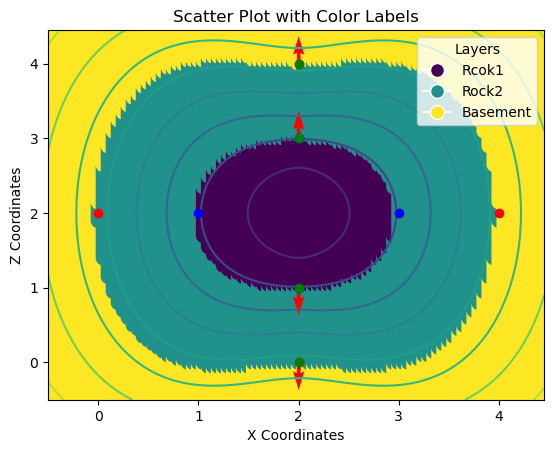

In [ ]:
input_position=[torch.tensor(data= [[0,2],[2,4],[4,2],[2,0]], dtype=torch.float32),torch.tensor(data=[[1,2],[2,3],[3,2],[2,1]],dtype=torch.float32)]

gradient_position = torch.tensor([[2., 4.], [2,0], [2,3],[2,1]],dtype=torch.float32)

gradient_value = torch.tensor([[0, 1.0], [0.,-1.0], [0, 1.0], [0.,-1.0]], dtype=torch.float32)

theta = torch.tensor((torch.pi/180.0) * (0.0))

rotation = torch.reshape(torch.stack([torch.cos(theta),-torch.sin(theta),torch.sin(theta),torch.cos(theta)]), (2,2))

scale = torch.tensor([[1,0],[0,0.4]], dtype=torch.float32)


Transformation_matrix = scale @ rotation

nugget_effect_grad = 0.001
nugget_effect_interface=0.001

intp = Ge_model(input_position=input_position, gradient_postion=gradient_position,gradient_value=gradient_value,nugget_effect_grad=nugget_effect_grad,nugget_effect_interface=nugget_effect_interface,Transformation_matrix=Transformation_matrix,
                plot_fig=True, plot_input_data=True, plot_scalar_field=True)

In [ ]:
def model(theta_degree=30.0,scale_x=1.0, scale_y=1.0, plot_fig=True, plot_input_data=False, plot_scalar_field=False):
    
    input_position=[torch.tensor(data= [[0,2],[2,4],[4,2],[2,0]], dtype=torch.float32),torch.tensor(data=[[1,2],[2,3],[3,2],[2,1]],dtype=torch.float32)]

    gradient_position = torch.tensor([[2., 4.], [2,0], [2,3],[2,1]],dtype=torch.float32)

    gradient_value = torch.tensor([[0, 1.0], [0.,-1.0], [0, 1.0], [0.,-1.0]], dtype=torch.float32)

    theta = torch.tensor((torch.pi/180.0) * (theta_degree))

    rotation = torch.reshape(torch.stack([torch.cos(theta),-torch.sin(theta),torch.sin(theta),torch.cos(theta)]), (2,2))

    scale = torch.tensor([[scale_x,0],[0,scale_y]], dtype=torch.float32)

    Transformation_matrix = scale @ rotation

    nugget_effect_grad = 0.001
    nugget_effect_interface=0.001

    intp = Ge_model(input_position=input_position, gradient_postion=gradient_position,gradient_value=gradient_value,nugget_effect_grad=nugget_effect_grad,nugget_effect_interface=nugget_effect_interface,Transformation_matrix=Transformation_matrix,
                    plot_fig=True, plot_input_data=True, plot_scalar_field=False)
    return intp.reshape(-1)

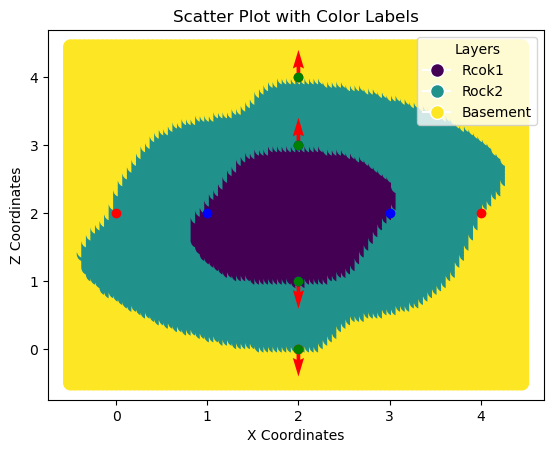

In [ ]:
scalar_field = model(theta_degree=-60,scale_x=1.0,scale_y=0.3)

In [ ]:
reshaped_scalar_field = scalar_field
range_data = torch.max(reshaped_scalar_field) -torch.min(reshaped_scalar_field)
seed =42
torch.manual_seed(seed)
shape_scalar_field = reshaped_scalar_field.shape
y_obs = reshaped_scalar_field + 0.05* range_data *torch.normal(size=shape_scalar_field,mean= 0.0,std=1.0, dtype=torch.float32)

In [ ]:
def model_pyro(y_obs):
    theta = pyro.sample("theta", dist.Normal(0., 10.))
    #sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    sigma =10
    mean = model(theta_degree=theta, scale_x=1.0, scale_y=0.3)
    with pyro.plate("data", len(y_obs)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=y_obs)



Warmup:   0%|          | 0/2 [00:00, ?it/s]/var/folders/lr/h2867zhs72gcy61j6_cy0n0r0000gq/T/ipykernel_79716/2236898585.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor((torch.pi/180.0) * (theta_degree))
Sample: 100%|██████████| 2/2 [00:00,  3.39it/s, step size=2.00e+00, acc. prob=0.539]


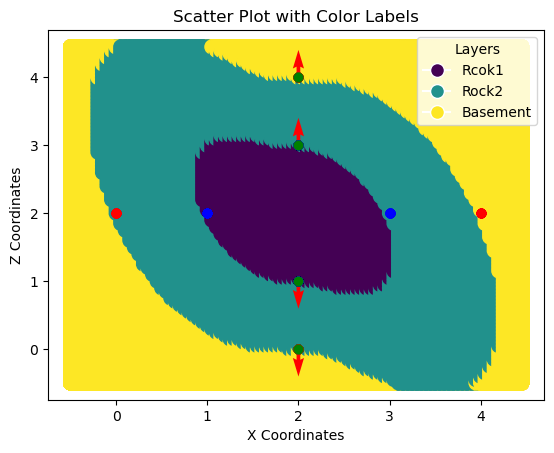

In [ ]:
from pyro.infer import MCMC, NUTS


nuts_kernel = NUTS(model_pyro)

mcmc = MCMC(nuts_kernel, num_samples=1, warmup_steps=1)
mcmc.run(y_obs)

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

In [ ]:
def model2(theta_degree=30.0,scale_x=1.0, scale_y=1.0, plot_fig=False, plot_input_data=False, plot_scalar_field=False):
    
    input_position=[torch.tensor(data= [[0,2],[2,4],[4,2],[2,0]], dtype=torch.float32),torch.tensor(data=[[1,2],[2,3],[3,2],[2,1]],dtype=torch.float32)]

    gradient_position = torch.tensor([[2., 4.], [2,0], [2,3],[2,1]],dtype=torch.float32)

    gradient_value = torch.tensor([[0, 1.0], [0.,-1.0], [0, 1.0], [0.,-1.0]], dtype=torch.float32)
    print(theta_degree)
    theta = torch.tensor((torch.pi/180.0) * (theta_degree))

    rotation = torch.reshape(torch.stack([torch.cos(theta),-torch.sin(theta),torch.sin(theta),torch.cos(theta)]), (2,2))

    scale = torch.tensor([[scale_x,0],[0,scale_y]], dtype=torch.float32)

    Transformation_matrix = scale @ rotation

    nugget_effect_grad = 0.001
    nugget_effect_interface=0.001

    intp = Ge_model(input_position=input_position, gradient_postion=gradient_position,gradient_value=gradient_value,nugget_effect_grad=nugget_effect_grad,nugget_effect_interface=nugget_effect_interface,Transformation_matrix=Transformation_matrix,
                    plot_fig=plot_fig, plot_input_data=plot_input_data, plot_scalar_field=plot_scalar_field)
    return intp.reshape(-1)

In [ ]:
def gempy_grad(*param):
    mean = model2(theta_degree=param[0][0], scale_x=1.0, scale_y=0.3)
    return mean

In [ ]:
from torch.autograd.functional import jacobian
from datetime import datetime

start_time = datetime.now()
a=torch.tensor(30.0).reshape(-1,1)
print(a.shape)
theta_data = tuple([a.clone().requires_grad_(True)])
mean = gempy_grad(theta_data)
end_time = datetime.now()
elapsed_time = end_time - start_time
print(f"Elapsed time for Gempy: {elapsed_time}")
start_time = datetime.now()
J = jacobian(gempy_grad, theta_data)
end_time = datetime.now()
elapsed_time = end_time - start_time
print(f"Elapsed time for Jacobian: {elapsed_time}")

torch.Size([1, 1])
torch.Size([1, 1])
Elapsed time for Gempy: 0:00:00.024479
torch.Size([1])
Elapsed time for Jacobian: 0:00:00.051065


/var/folders/lr/h2867zhs72gcy61j6_cy0n0r0000gq/T/ipykernel_79716/1783143699.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor((torch.pi/180.0) * (theta_degree))


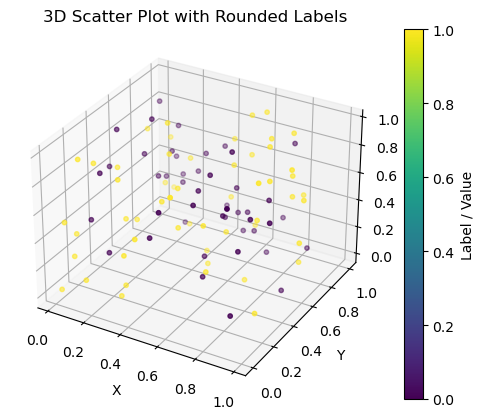

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting
import torch
import numpy as np

# Example data
points = np.random.rand(100, 3)
values = torch.round(torch.rand(100))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=values, cmap='viridis', s=10)

cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label("Label / Value")

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("3D Scatter Plot with Rounded Labels")

plt.show()